# Post Hoc Explaination on [Bank Loan Status](https://www.kaggle.com/datasets/zaurbegiev/my-dataset) dataset

# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics

import lime
import shap

from utils.xailib.explainers.lore_explainer import LoreTabularExplainer
from utils.xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Input Data Preparation


In [2]:
# Read the train data set
df_full = pd.read_csv("data/processed/df_full.csv")
df_full.describe().T 

count          mean           std      min  \
Loan Status                67158.0  7.560976e-01  4.294378e-01      0.0   
Current Loan Amount        67158.0  1.274733e+07  3.294150e+07  15422.0   
Term                       67158.0  7.301587e-01  4.438805e-01      0.0   
Credit Score               67158.0  1.104096e+03  1.524065e+03    585.0   
Annual Income              67158.0  1.376663e+06  1.132036e+06  76627.0   
Years in current job       67158.0  3.635338e+00  3.160727e+00      0.0   
Home Ownership             67158.0  1.930716e+00  9.535001e-01      0.0   
Purpose                    67158.0  3.546934e+00  1.567391e+00      0.0   
Monthly Debt               67158.0  1.839016e+04  1.218328e+04      0.0   
Years of Credit History    67158.0  1.821762e+01  7.007586e+00      3.6   
Number of Open Accounts    67158.0  1.111439e+01  4.985150e+00      0.0   
Number of Credit Problems  67158.0  1.648649e-01  4.761947e-01      0.0   
Current Credit Balance     67158.0  2.951243e+05  3.818955e+05      0.0   
Maximum Open Credit        67158.0  7.666954e+05  8.763779e+06      0.0   
Bankruptcies               67158.0  1.157569e-01  3.484944e-01      0.0   
Tax Liens                  67158.0  2.778522e-02  2.533382e-01      0.0   

                                 25%          50%          75%           max  
Loan Status                     1.00        1.000        1.000  1.000000e+00  
Current Loan Amount        179943.50   313940.000   532064.500  1.000000e+08  
Term                            0.00        1.000        1.000  1.000000e+00  
Credit Score                  707.00      726.000      742.000  7.510000e+03  
Annual Income              847134.00  1168158.000  1649409.000  1.655574e+08  
Years in current job            1.00        2.000        6.000  1.000000e+01  
Home Ownership                  1.00        2.000        3.000  3.000000e+00  
Purpose                         3.00        3.000        3.000  1.400000e+01  
Monthly Debt                10152.08    16127.295    23896.015  4.358433e+05  
Years of Credit History        13.50       17.000       21.700  7.050000e+01  
Number of Open Accounts         8.00       10.000       14.000  5.600000e+01  
Number of Credit Problems       0.00        0.000        0.000  1.500000e+01  
Current Credit Balance     112917.00   210102.000   368063.250  3.287897e+07  
Maximum Open Credit        276061.50   471141.000   789899.000  1.539738e+09  
Bankruptcies                    0.00        0.000        0.000  7.000000e+00  
Tax Liens                       0.00        0.000        0.000  1.500000e+01

## Data Splitting

`Loan Status` is our target variable, the one that we want to predict

In [3]:
target = 'Loan Status'

First, we split train and test

In [4]:
feature_names = df_full.columns.to_list()[1:]

In [5]:
test_size = 0.25
random_state = 3
X_train, X_test, Y_train, Y_test = train_test_split(df_full[feature_names], 
                                                        df_full[target],
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=df_full[target])

In [6]:
idtrain = X_train.index
idtest = X_test.index

In [7]:
train_dataset = df_full.drop(idtest,axis='index')
test_dataset = df_full.drop(idtrain,axis='index')

The black box that we have chosen for the classification is the well known XGBoost model.\
This is a tree-based model that performs well on tabular data.

In [8]:
bb = xgb.XGBClassifier().fit(X_train, Y_train)

In [9]:
# Make predictions on the test set
y_pred = bb.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7952948183442525


# Instance selection

In [10]:
inst = X_test[0:10]

# SHAP


SHAP uses game theory and shapley values to provide an explanation.

The general working of SHAP in the classical Kernel mode (default mode) is:

- Sample coalitions $z_k'\in\{0,1\}^M,\quad{}k\in\{1,\ldots,K\}$ (1 = feature present in coalition, 0 = feature absent).
- Get prediction for each $z_k'$ by first converting $z_k'$ to the original feature space and then applying model $\hat{f}: \hat{f}(h_x(z_k'))$
- Compute the weight for each $z_k'$ with the SHAP kernel.
- Fit weighted linear model.
- Return Shapley values $\phi_k$, the coefficients from the linear model.

SHAP provides several explanators, optimized for different objectives, and several visualization options.

- Kernel Explainer, it is the *real* agnostic method for computing Shap values. Hence, it works for every kind of ML model (quite slow).
- Linear Explainer, for explaining linear models. It is an exact method. It allows for an analysis with independent variables, as well as for correlated ones (you have to estimates the variables covariance matrix).
- Tree Explainer, for explaining tree-based models (tree and ensambles). Is is an exact algorithm. (Difference: conditional expectation $E_{X_j|X_{-j}}(\hat{f}(x)|x_j)$)
- Gradient Explainer, for explaining deep learning models. It is based on Integrated Gradient and it is an approximation algorithm.
- Deep Explainer, for explaining deep learning models. It is based on DEEPLift and the method computes an approximation algorithm (faster than Gradient Explainer).

For our random forest we can use the tree explainer

In [32]:
shap_tree_exp = shap.TreeExplainer(bb)
shap_values_tree = shap_tree_exp.shap_values(inst)

The summary plot gives us an overall view of the shapley values for a bunch of records

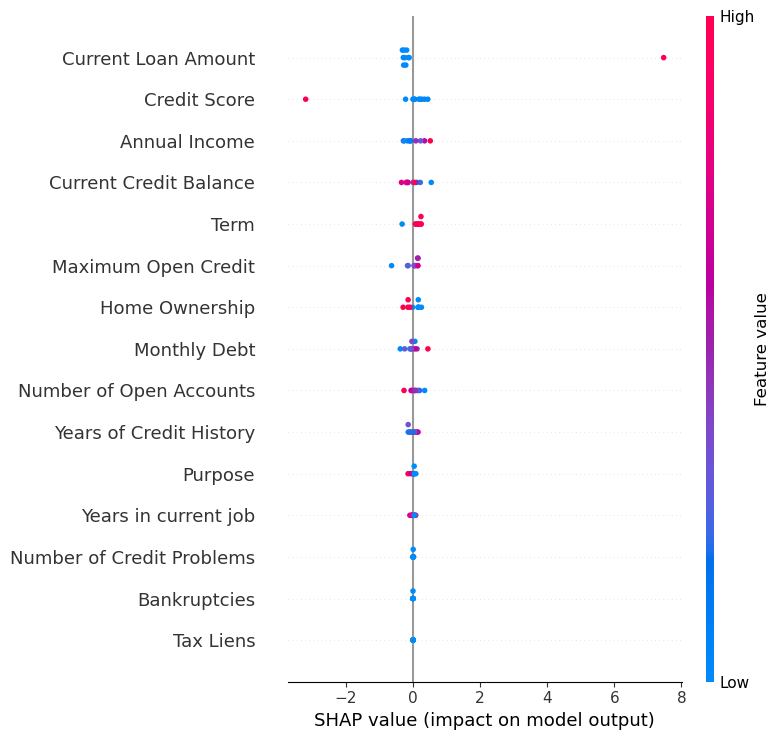

In [33]:
shap.summary_plot(shap_values_tree, inst)

In [34]:
tree_explanation_object = shap_tree_exp(inst)

In [35]:
tree_explanation_object

.values =
array([[-2.69019008e-01,  2.43209183e-01,  3.42260629e-01,
         3.43378097e-01,  3.10568977e-02,  1.65208235e-01,
         3.61715630e-02, -3.85414772e-02,  1.12046190e-01,
         6.62405714e-02,  1.06483577e-02, -1.50078461e-01,
         1.47279114e-01,  7.45726458e-04,  1.19359756e-03],
       [-3.17859948e-01, -3.25221360e-01,  2.06129923e-01,
        -9.42762420e-02, -3.57905664e-02, -1.50837630e-01,
         3.45077701e-02, -3.40817869e-02,  5.02552018e-02,
        -2.68622726e-01,  5.45768626e-03, -1.95790410e-01,
         3.92251052e-02, -5.14963758e-04,  2.14200164e-03],
       [-1.89311013e-01,  1.66777566e-01,  5.83631769e-02,
        -2.64896572e-01,  6.64506629e-02,  1.51480615e-01,
         8.36320296e-02, -2.50674009e-01,  6.45464519e-03,
        -3.46860215e-02,  1.38721382e-02,  3.64309479e-03,
        -1.64257780e-01, -9.78647964e-04,  2.97864876e-03],
       [-1.33612320e-01,  2.36070424e-01,  2.62758285e-01,
        -1.02765113e-01, -5.26891761e-02, -

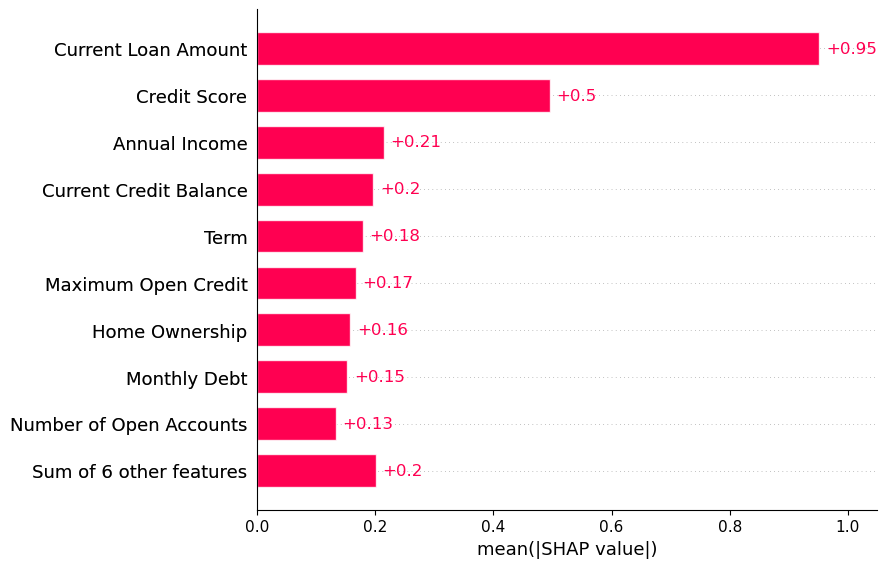

In [38]:
shap.plots.bar(tree_explanation_object)

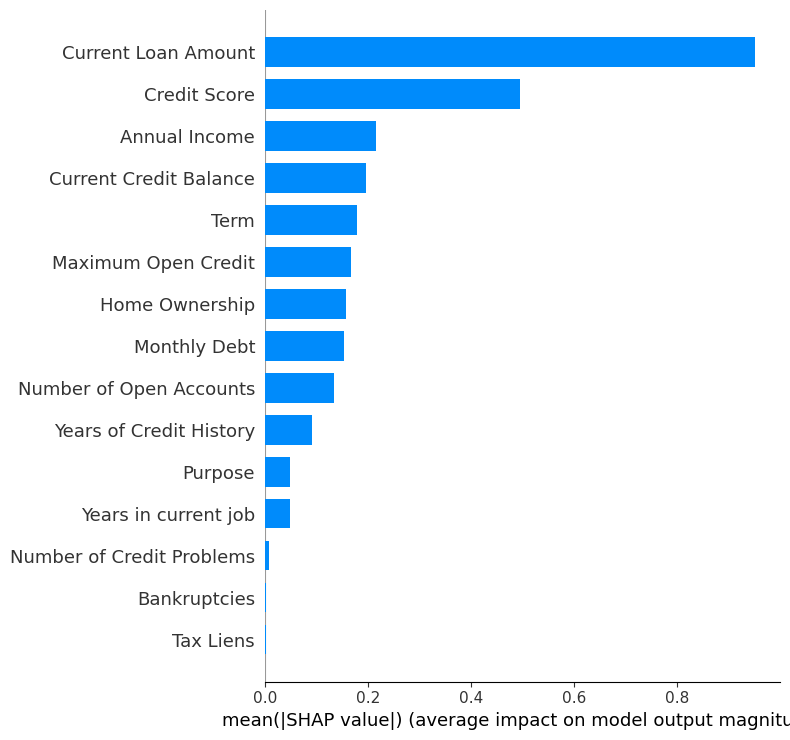

In [39]:
shap.summary_plot(shap_values_tree, inst, plot_type='bar')

We can use dependence plot to focus on one variable.

- Each dot is a single prediction (row) from the dataset.
- The x-axis is the value of the feature (from the X matrix).
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction.
- The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

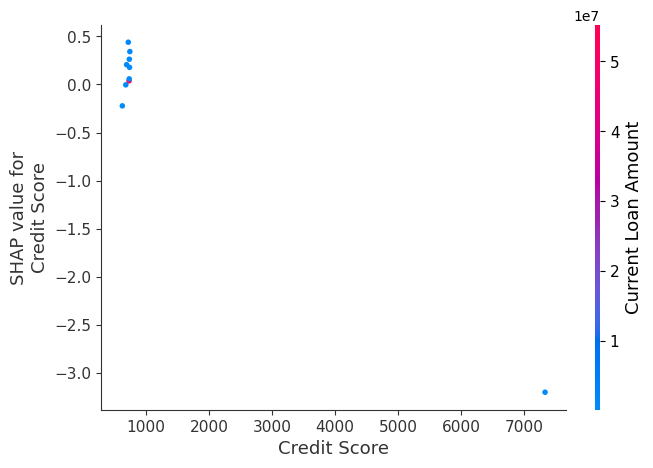

In [40]:
shap.dependence_plot("Credit Score", shap_values_tree, inst)

We can explore the interactions between variables.
SHAP interaction values are a generalization of SHAP values to higher order interactions.
A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

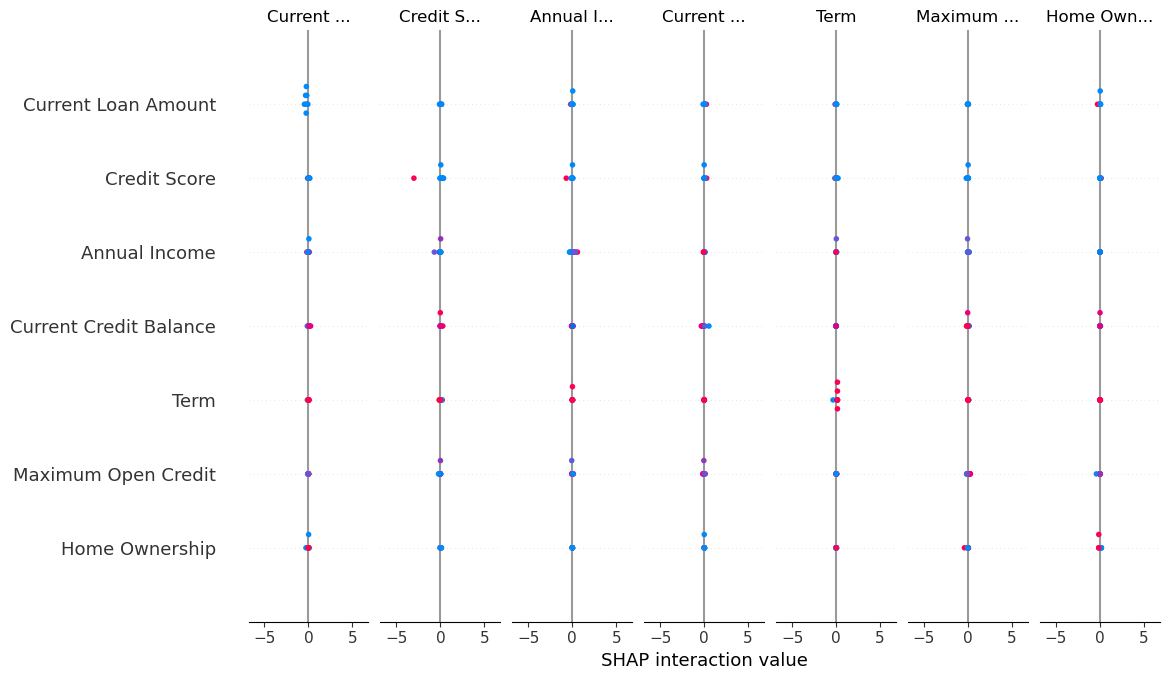

In [41]:
shap_interaction_values_tree = shap_tree_exp.shap_interaction_values(inst)
shap.summary_plot(shap_interaction_values_tree, inst)

Running a dependence plot on the SHAP interaction values a allows us to separately observe the main effects and the interaction effects.

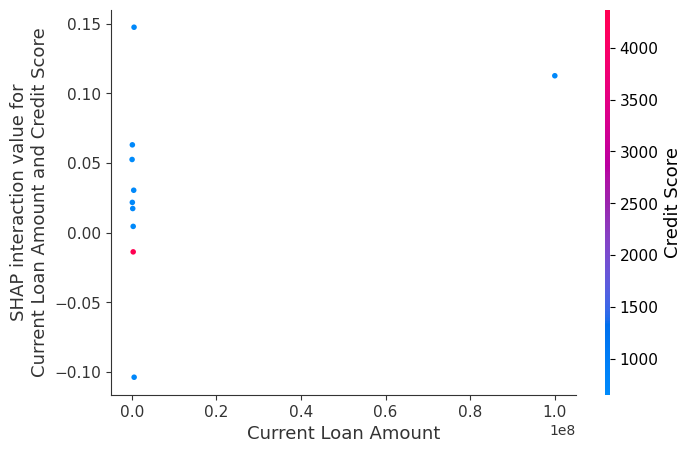

In [42]:
shap.dependence_plot(
    ("Current Loan Amount", "Credit Score"),
    shap_interaction_values_tree, inst
)

SHAP also provides some nice interactive visualizations using javascript

In [43]:
shap.initjs()
shap.force_plot(shap_tree_exp.expected_value, shap_values_tree, inst)

For now we've explored our model on a global level. Let's now look at local explanation using SHAP.

In [44]:
shap.initjs()
shap.force_plot(shap_tree_exp.expected_value, shap_values_tree[0,:], feature_names)

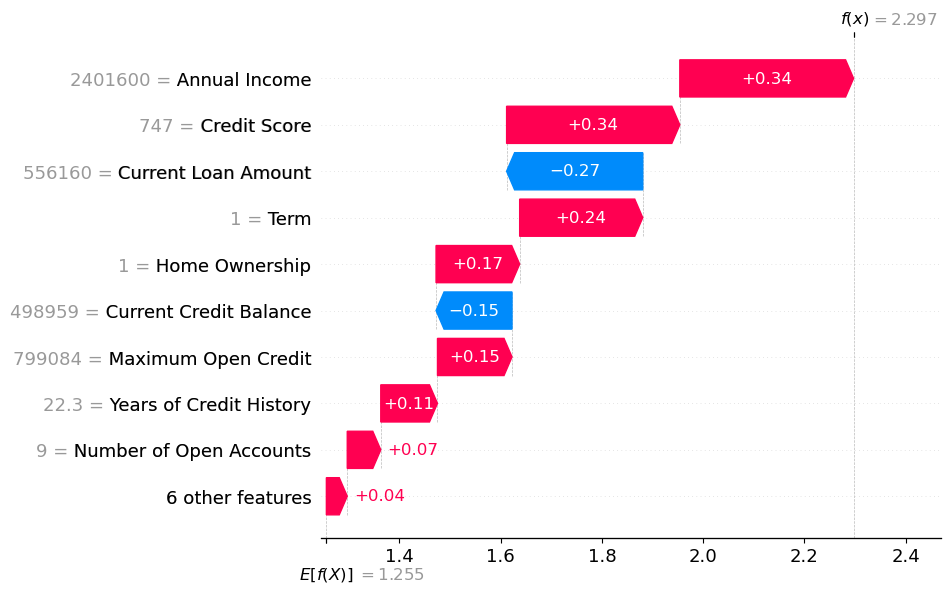

In [45]:
shap.plots.waterfall(tree_explanation_object[:,:][0])

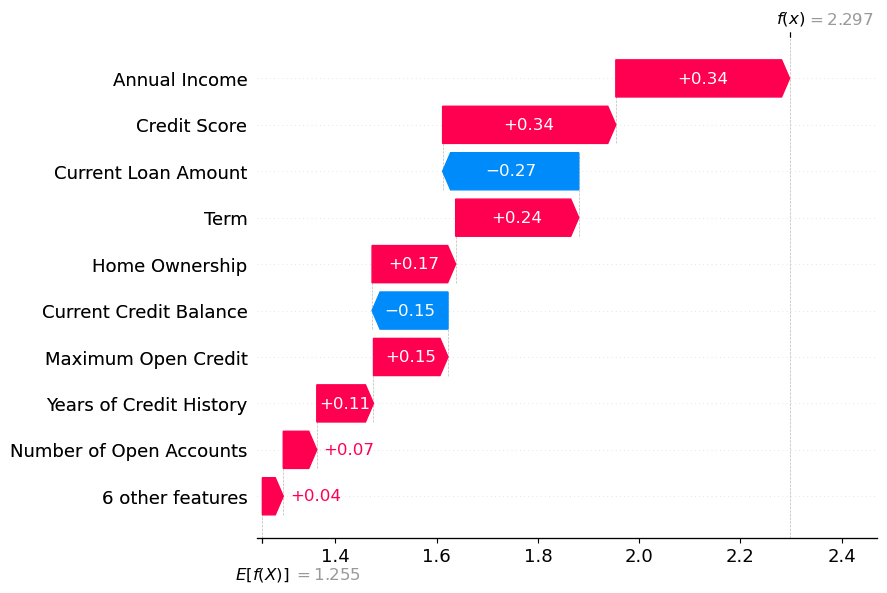

In [46]:
shap.plots._waterfall.waterfall_legacy(shap_tree_exp.expected_value, shap_values_tree[0], feature_names=feature_names)

Another example

Let's try a different explainer: before we used the TreeExplainer, but there are other explainers available in SHAP. Since we are dealing with a RandomForest, another possibility could be the KernelExplainer, that is completley agnostic.

KernelExplainer requires in input the predict_proba of the black-box we want to explain and a sample of the data. In this simple example we use just the first 20 records of the test set, but in principle you can pass whatever representation of your data, such as the centroids obtained from a clustering algorithm.

In [63]:
shap_kernel_exp = shap.KernelExplainer(bb.predict_proba, inst)
shap_values_kernel = shap_kernel_exp.shap_values(inst)

AttributeError: property 'feature_names_in_' of 'XGBClassifier' object has no setter

Let's now see how the explanation change

In [35]:
shap.initjs()
shap.force_plot(shap_kernel_exp.expected_value[0], shap_values_kernel[0], X_test[0:200])

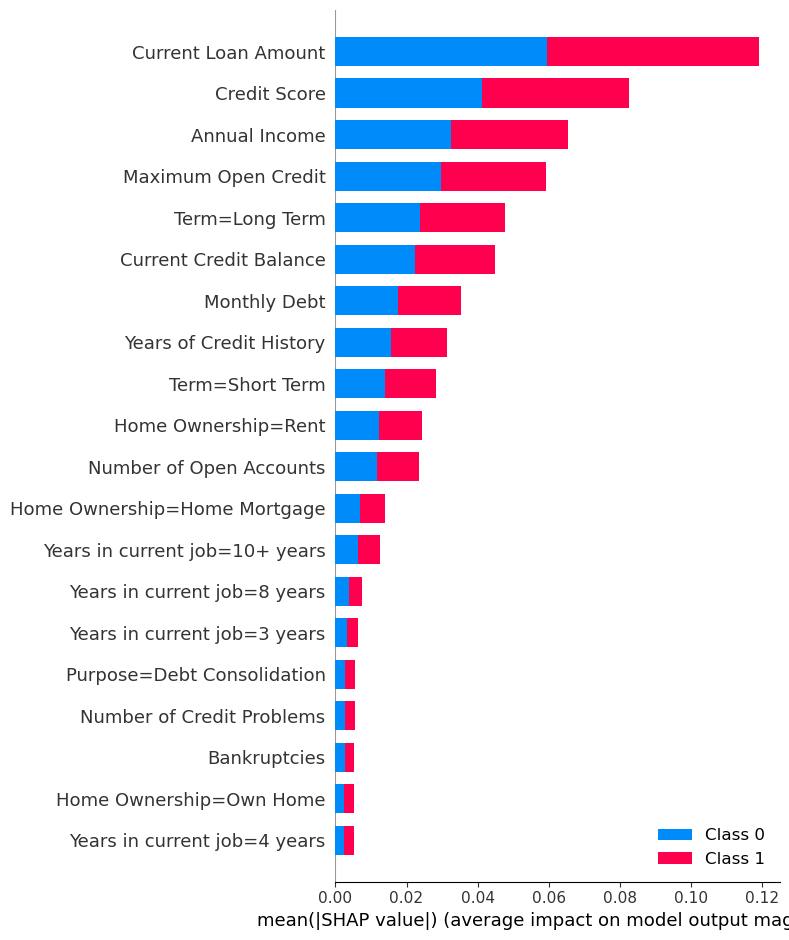

In [36]:
shap.summary_plot(shap_values_kernel, X_test[0:200])

In [37]:
shap.initjs()
shap.force_plot(shap_kernel_exp.expected_value[1], shap_values_kernel[1][1,:], feature_names)

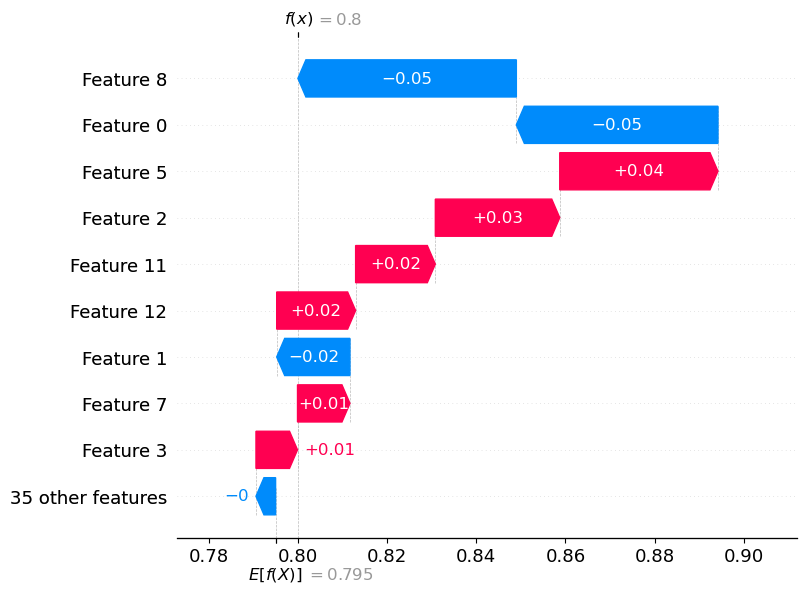

In [38]:
shap.plots._waterfall.waterfall_legacy(shap_kernel_exp.expected_value[1], shap_values_kernel[1][1,:])

# LIME

LIME focuses on local explanations. The idea is: it generates a set of neighbours, on them it trains a linear model.

- Select your instance of interest for which you want to have an explanation of its black box prediction.
- Perturb your dataset and  get the black box predictions for these new points.
- Weight the new samples according to their proximity to the instance of interest.
- Train a weighted, interpretable model on the dataset with the variations.
- Explain the prediction by interpreting the local model.


There are 2 kinds of neighbourhood generation:

- Gaussian
- Lhs (Latin Hypercube Sampling)

We first initialize the lime explainer on our train data, providing the names of our features

In [53]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = feature_names)

Then we can explain each data point locally
We can see each explanation from the "perspective" of the class that we want to focus on

In [61]:
inst_i = inst.values[0]

In [62]:
exp = explainer.explain_instance(inst_i, bb.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

In [64]:
exp = explainer.explain_instance(inst_i, bb.predict_proba, labels=[0])
exp.show_in_notebook(show_table=True, show_all=False)

We can also "cut" our explanation and modify the visualization

In [65]:
exp = explainer.explain_instance(inst_i, bb.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

You can also manage other options:

- top_labels: if not None, ignore labels and produce explanations for
                the K labels with highest prediction probabilities, where K is
                this parameter.
- num_features: maximum number of features present in explanation
            num_samples: size of the neighborhood to learn the linear model
- distance_metric: the distance metric to use for weights.
- model_regressor: sklearn regressor to use in explanation. Defaults
                to Ridge regression in LimeBase. Must have model_regressor.coef_
                and 'sample_weight' as a parameter to model_regressor.fit()
- sampling_method: Method to sample synthetic data. Defaults to Gaussian
                sampling. Can also use Latin Hypercube Sampling.

We can provide the explanation as a pyplot figure

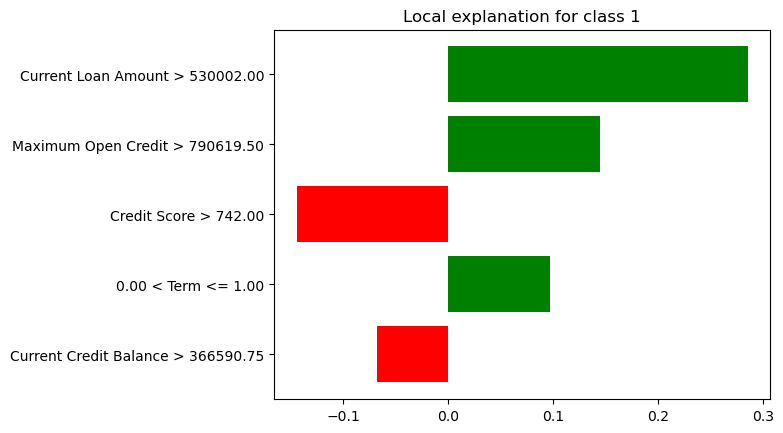

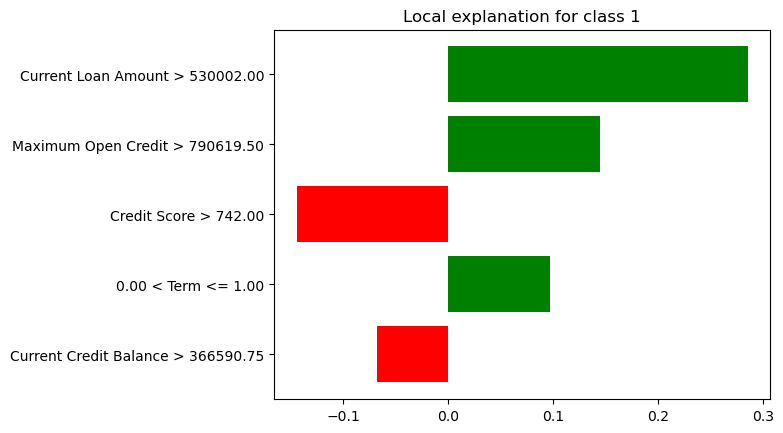

In [66]:
exp.as_pyplot_figure()
#Old line - exp.as_pyplot_figure(label=0)"

Or manipulate the values as a list

In [67]:
exp.as_list()
#Old line - exp.as_list(0)"

[('Current Loan Amount > 530002.00', 0.2854193249045452),
 ('Maximum Open Credit > 790619.50', 0.14468553511338184),
 ('Credit Score > 742.00', -0.14435350975303926),
 ('0.00 < Term <= 1.00', 0.0967234832576561),
 ('Current Credit Balance > 366590.75', -0.06809360392975888)]

In [46]:
exp.as_map()

{1: [(42, 0.3369287813370761),
  (1, 0.086180554617632),
  (2, 0.07377960095635713),
  (0, -0.05921814303835184),
  (11, 0.03809850290584683)]}

# Lore

Lore is an algorithm developed internally to the KDDLab. To use it we will use the xai lib that we imported at the beginning. Note that shap and lime are wrappend in the xai lib, so if you want you can replicate the previous part using the xai lib.

We then use the `sklearn_classifier_wrapper` from xai lib to wrap our black box and make it ready to explain

In [11]:
bbox = sklearn_classifier_wrapper(bb)

Now e could also use the imlpementations of SHAP and Lime that are present in the XAI-lib

In [12]:
explainer = LoreTabularExplainer(bbox)

Lore uses various type of neighborhood generation to provide a local explanation based on factuals and counterfactuals

In [17]:
idx = 0
inst_i = inst.iloc[idx].values

In [18]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'rndgen', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(df_full, target, config)
exp = explainer.explain(inst_i)

In [20]:
print('Instance ', inst_i)
print('True class ', Y_test.iloc[idx])
print('Predicted class ', bb.predict(inst_i.reshape(1, -1)))

Instance  [5.561600e+05 1.000000e+00 7.470000e+02 2.401600e+06 1.000000e+00
 1.000000e+00 3.000000e+00 1.841214e+04 2.230000e+01 9.000000e+00
 0.000000e+00 4.989590e+05 7.990840e+05 0.000000e+00 0.000000e+00]
True class  1
Predicted class  [1]


In [21]:
exp.plotRules()

In [22]:
exp.plotCounterfactualRules()

# DiCE

In [23]:
import dice_ml
from dice_ml.utils import helpers # helper functions

In [24]:
numeric_columns = train_dataset.columns.to_list()

In [27]:
d = dice_ml.Data(dataframe=train_dataset, continuous_features=numeric_columns[1:], outcome_name=target)

In [28]:
# Using sklearn backend
m = dice_ml.Model(model=bb, backend="sklearn")
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="random")

In [31]:
e1 = exp.generate_counterfactuals(inst, total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

Query instance (original outcome : 1)


Current Loan Amount  Term  Credit Score  Annual Income  \
0             556160.0     1         747.0      2401600.0   

   Years in current job  Home Ownership  Purpose  Monthly Debt  \
0                     1               1        3  18412.140625   

   Years of Credit History  Number of Open Accounts  \
0                22.299999                      9.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        0.0                498959.0             799084.0   

   Bankruptcies  Tax Liens  Loan Status  
0           0.0        0.0            1


Diverse Counterfactual set (new outcome: 0.0)


Current Loan Amount Term Credit Score Annual Income Years in current job  \
0                   -    -       6804.0             -                    -   
1                   -    -       3412.6             -                    -   

  Home Ownership Purpose        Monthly Debt Years of Credit History  \
0              -       -  18413.039999999986       23.00000000000001   
1              -       -  18413.039999999986                    64.6   

  Number of Open Accounts Number of Credit Problems Current Credit Balance  \
0                    37.3                         -                      -   
1                       -                         -                      -   

  Maximum Open Credit Bankruptcies Tax Liens Loan Status  
0                   -            -         -         0.0  
1                   -            -         -         0.0

Query instance (original outcome : 1)


Current Loan Amount  Term  Credit Score  Annual Income  \
0             455246.0     0         696.0       936130.0   

   Years in current job  Home Ownership  Purpose  Monthly Debt  \
0                     8               3        3  14665.910156   

   Years of Credit History  Number of Open Accounts  \
0                     13.5                     19.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        0.0                411540.0            1244188.0   

   Bankruptcies  Tax Liens  Loan Status  
0           0.0        0.0            1


Diverse Counterfactual set (new outcome: 0.0)


Current Loan Amount Term Credit Score Annual Income Years in current job  \
0                   -    -            -             -                    -   
1                   -    -       6516.7             -                    -   

  Home Ownership Purpose Monthly Debt Years of Credit History  \
0              -       -      83123.8      14.099999999999998   
1              -       -     14666.01      14.099999999999998   

  Number of Open Accounts Number of Credit Problems Current Credit Balance  \
0                       -                         -             18072261.1   
1                       -                         -             21640159.9   

  Maximum Open Credit Bankruptcies Tax Liens Loan Status  
0                   -            -         -         0.0  
1                   -            -         -         0.0

Query instance (original outcome : 1)


Current Loan Amount  Term  Credit Score  Annual Income  \
0             128304.0     1         737.0       563673.0   

   Years in current job  Home Ownership  Purpose  Monthly Debt  \
0                     7               1        3   12259.94043   

   Years of Credit History  Number of Open Accounts  \
0                     33.0                     11.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        0.0                264841.0             406164.0   

   Bankruptcies  Tax Liens  Loan Status  
0           0.0        0.0            1


Diverse Counterfactual set (new outcome: 0.0)


Current Loan Amount Term Credit Score Annual Income Years in current job  \
0                   -    -       6010.8             -                    -   
1                   -    -       5604.8             -                    -   

  Home Ownership Purpose Monthly Debt Years of Credit History  \
0              -       -     12260.04                       -   
1              -       -     12260.04                       -   

  Number of Open Accounts Number of Credit Problems Current Credit Balance  \
0                       -                         -                      -   
1                       -                         -                      -   

  Maximum Open Credit Bankruptcies Tax Liens Loan Status  
0                   -            -         -         0.0  
1                   -            -         -         0.0

Query instance (original outcome : 1)


Current Loan Amount  Term  Credit Score  Annual Income  \
0             133364.0     1         739.0       858306.0   

   Years in current job  Home Ownership  Purpose  Monthly Debt  \
0                     5               3        7   5650.600098   

   Years of Credit History  Number of Open Accounts  \
0                      9.0                      7.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        0.0                158821.0             477664.0   

   Bankruptcies  Tax Liens  Loan Status  
0           0.0        0.0            1


Diverse Counterfactual set (new outcome: 0.0)


Current Loan Amount Term Credit Score Annual Income Years in current job  \
0                   -    -       5301.7             -                    -   
1                   -    -            -             -                    -   

  Home Ownership Purpose       Monthly Debt Years of Credit History  \
0              -       -  5651.000000000002                       -   
1              -       -           433156.5                       -   

  Number of Open Accounts Number of Credit Problems Current Credit Balance  \
0                    19.7                         -                      -   
1                       -                         -             27510405.2   

  Maximum Open Credit Bankruptcies Tax Liens Loan Status  
0                   -            -         -         0.0  
1                   -            -         -         0.0

Query instance (original outcome : 0)


Current Loan Amount  Term  Credit Score  Annual Income  \
0             329846.0     1        7330.0      1614202.0   

   Years in current job  Home Ownership  Purpose  Monthly Debt  \
0                     7               1        3  36319.261719   

   Years of Credit History  Number of Open Accounts  \
0                     16.1                     12.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        0.0                484367.0             877690.0   

   Bankruptcies  Tax Liens  Loan Status  
0           0.0        0.0            0


Diverse Counterfactual set (new outcome: 1.0)


Current Loan Amount Term Credit Score Annual Income Years in current job  \
0          72052552.6    -            -             -                    -   
1          34423978.9    -            -             -                    -   

  Home Ownership Purpose       Monthly Debt Years of Credit History  \
0            0.0       -  36320.05999999999      17.000000000000014   
1              -       -  36320.05999999999      17.000000000000014   

  Number of Open Accounts Number of Credit Problems Current Credit Balance  \
0                       -                         -                      -   
1                       -                         -                      -   

  Maximum Open Credit Bankruptcies Tax Liens Loan Status  
0                   -            -         -         1.0  
1                   -            -         -         1.0

Query instance (original outcome : 1)


Current Loan Amount  Term  Credit Score  Annual Income  \
0             535436.0     1         722.0      2076206.0   

   Years in current job  Home Ownership  Purpose  Monthly Debt  \
0                     4               3        3  19550.810547   

   Years of Credit History  Number of Open Accounts  \
0                     13.5                     10.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        0.0                360183.0             646602.0   

   Bankruptcies  Tax Liens  Loan Status  
0           0.0        0.0            1


Diverse Counterfactual set (new outcome: 0.0)


Current Loan Amount Term Credit Score Annual Income Years in current job  \
0                   -    -            -             -                    -   
1                   -    -            -             -                    -   

  Home Ownership Purpose Monthly Debt Years of Credit History  \
0              -       -      69437.3      14.099999999999998   
1              -       -     244333.9      14.099999999999998   

  Number of Open Accounts Number of Credit Problems Current Credit Balance  \
0                       -                         -                      -   
1                       -                         -                      -   

  Maximum Open Credit Bankruptcies Tax Liens Loan Status  
0                   -            -         -         0.0  
1                   -            -         -         0.0

Query instance (original outcome : 1)


Current Loan Amount  Term  Credit Score  Annual Income  \
0             223674.0     1         742.0       649059.0   

   Years in current job  Home Ownership  Purpose  Monthly Debt  \
0                     3               3        4   5949.660156   

   Years of Credit History  Number of Open Accounts  \
0                     13.6                      4.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        0.0                 25061.0              58124.0   

   Bankruptcies  Tax Liens  Loan Status  
0           0.0        0.0            1


Diverse Counterfactual set (new outcome: 0.0)


Current Loan Amount Term Credit Score Annual Income Years in current job  \
0                   -    -            -             -                    -   
1                   -    -       3324.1             -                    -   

  Home Ownership Purpose       Monthly Debt Years of Credit History  \
0              -    13.0           174329.5      14.099999999999998   
1              -       -  5950.060000000001      14.099999999999998   

  Number of Open Accounts Number of Credit Problems Current Credit Balance  \
0                       -                         -                      -   
1                       -                         -                      -   

  Maximum Open Credit Bankruptcies Tax Liens Loan Status  
0                   -            -         -         0.0  
1                   -            -         -         0.0

Query instance (original outcome : 1)


Current Loan Amount  Term  Credit Score  Annual Income  \
0             332706.0     1         683.0      1580363.0   

   Years in current job  Home Ownership  Purpose  Monthly Debt  \
0                     6               1        3  16857.179688   

   Years of Credit History  Number of Open Accounts  \
0                     19.6                      7.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        0.0                423529.0             556644.0   

   Bankruptcies  Tax Liens  Loan Status  
0           0.0        0.0            1


Diverse Counterfactual set (new outcome: 0.0)


Current Loan Amount Term Credit Score Annual Income Years in current job  \
0                   -    -       3440.8             -                    -   
1                   -    -       3331.5             -                    -   

  Home Ownership Purpose        Monthly Debt Years of Credit History  \
0              -       -  16858.079999999987                    39.3   
1              -       -  16858.079999999987      20.000000000000007   

  Number of Open Accounts Number of Credit Problems Current Credit Balance  \
0                       -                         -                      -   
1                       -                       1.3                      -   

  Maximum Open Credit Bankruptcies Tax Liens Loan Status  
0                   -            -         -         0.0  
1                   -            -         -         0.0

Query instance (original outcome : 1)


Current Loan Amount  Term  Credit Score  Annual Income  \
0          100000000.0     1         734.0      4867021.0   

   Years in current job  Home Ownership  Purpose  Monthly Debt  \
0                     1               1        3  12694.849609   

   Years of Credit History  Number of Open Accounts  \
0                22.299999                     10.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        0.0                387714.0             614988.0   

   Bankruptcies  Tax Liens  Loan Status  
0           0.0        0.0            1


Diverse Counterfactual set (new outcome: 0.0)


Current Loan Amount Term Credit Score Annual Income Years in current job  \
0            244080.4    -            -             -                    -   
1            777454.7    -            -             -                    -   

  Home Ownership Purpose        Monthly Debt Years of Credit History  \
0              -       -            168090.0       23.00000000000001   
1            2.0       -  12695.050000000001                    49.3   

  Number of Open Accounts Number of Credit Problems Current Credit Balance  \
0                       -                       0.3                      -   
1                       -                         -             27300629.6   

  Maximum Open Credit Bankruptcies Tax Liens Loan Status  
0                   -            -       4.2         0.0  
1         155629698.6          4.3       1.3         0.0

Query instance (original outcome : 1)


Current Loan Amount  Term  Credit Score  Annual Income  \
0              71544.0     1         628.0      1211573.0   

   Years in current job  Home Ownership  Purpose  Monthly Debt  \
0                     6               1        5   5178.450195   

   Years of Credit History  Number of Open Accounts  \
0                     10.6                      2.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        0.0                187131.0             230274.0   

   Bankruptcies  Tax Liens  Loan Status  
0           0.0        0.0            1


Diverse Counterfactual set (new outcome: 0.0)


Current Loan Amount Term Credit Score Annual Income Years in current job  \
0                   -    -            -             -                    -   
1                   -    -            -             -                    -   

  Home Ownership Purpose       Monthly Debt Years of Credit History  \
0              -       -  5179.050000000002                    10.0   
1              -       -  5179.050000000002      11.099999999999998   

  Number of Open Accounts Number of Credit Problems Current Credit Balance  \
0                       -                         -                      -   
1                       -                         -             20408215.2   

  Maximum Open Credit Bankruptcies Tax Liens Loan Status  
0                   -          6.1         -         0.0  
1                   -            -         -         0.0